In [4]:
import pandas as pd
import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup
import matplotlib.pyplot as plt
from pyteomics import mgf

In [15]:
# Load mokapot output
file_path = "../mokapot.psms.txt"
df = pd.read_csv(file_path, sep="\t")

# Display the first few rows
print(df.head())

# Select a peptide identification for analysis
peptide_row = df.iloc[0]  # Change index as needed

# Extract key information
scan_nr = peptide_row["SpecId"].split("|")[2].split("scan=")[1]
filename = peptide_row["filename"]
peptide_sequence = peptide_row["Peptide"]
exp_mass = peptide_row["ExpMass"]
calc_mass = peptide_row["CalcMass"]

      ScanNr                                        filename  \
0  1685260.0   part_6635.193557739258_7298.712913513184.mzml   
1  1405929.0   part_5971.674201965332_6635.193557739258.mzml   
2  1778537.0   part_6635.193557739258_7298.712913513184.mzml   
3  1072846.0  part_4644.6354904174805_5308.154846191406.mzml   
4  1639384.0   part_6635.193557739258_7298.712913513184.mzml   

                                             Peptide    ExpMass   CalcMass  \
0             LLPHIPADQFPAQALAC[Carbamidomethyl]ELYK  2392.8170  2394.2405   
1  TLC[Carbamidomethyl]VVQEGFPTYGGLEGGAM[Oxidatio...  2392.8170  2386.0935   
2                                  ELLSQYDFPGDDTPIVR  1963.3787  1963.9528   
3                                    NIFGYQYTIPTHQGR  1795.3022  1793.8850   
4                                       GAEQIYIPVLIK  1347.0984  1342.7860   

   Label                                             SpecId  mokapot score  \
0   True  1685260|part_6635.193557739258_7298.7129135131...      25.

In [9]:
print(f"Analyzing Peptide: {peptide_sequence} (Exp: {exp_mass}, Calc: {calc_mass})")

# Load MGF file (change filename to match your dataset)
mgf_file = f"../LFQ_Orbitrap_AIF_Ecoli_01.mgf"  # Ensure correct MGF path
spectra = list(mgf.read(mgf_file))

Analyzing Peptide: LLPHIPADQFPAQALAC[Carbamidomethyl]ELYK (Exp: 2392.817, Calc: 2394.2405)


372061


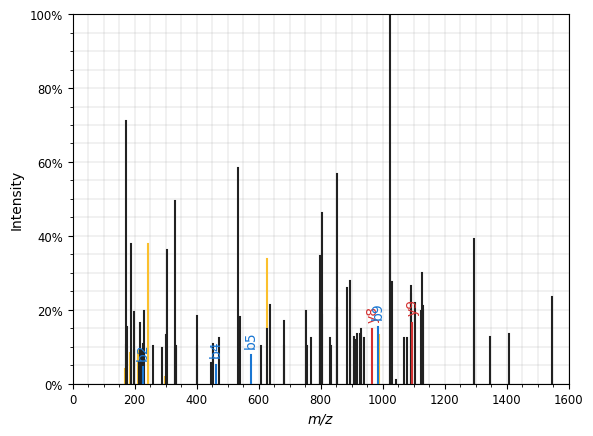

In [32]:
# Find the spectrum for the scan number
spectrum = None
print(scan_nr)
for spec in spectra:
    if str(scan_nr) in spec["params"]["title"].split("scan=")[1]:  # Check scan number match
        
        spectrum = spec
        break

if spectrum:
    # Convert to spectrum_utils format
    spec = sus.MsmsSpectrum(
        spectrum["params"]["title"],
        spectrum["params"]["pepmass"][0],  # Precursor mass
        2, #int(spectrum["params"]["charge"][0]),  # Charge state
        spectrum["m/z array"],  # m/z values
        spectrum["intensity array"],  # Intensities
    )

    # Annotate the spectrum with the peptide sequence
    spec.annotate_proforma(
        peptide_sequence,
        fragment_tol_mass=20,
        fragment_tol_mode="ppm",
        ion_types="abcxyzImpr",
    )

    # Plot the spectrum
    sup.spectrum(spec)
    plt.show()
else:
    print(f"No spectrum found for scan {scan_nr}")

In [ ]:
import pandas as pd
import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup
import matplotlib.pyplot as plt
from pyteomics import mgf
import random

# Load mokapot output
file_path = "../mokapot.psms.txt"
df = pd.read_csv(file_path, sep="\t")

# Identify scan numbers that appear multiple times
duplicated_scans = df[df.duplicated(subset=["ScanNr"], keep=False)]

# Group by scan number
grouped_scans = duplicated_scans.groupby("ScanNr")

# Randomly sample a few scan numbers with multiple identifications
sampled_scans = random.sample(
    list(grouped_scans.groups.keys()), min(5, len(grouped_scans))
)

# Path to MGF file (ensure correct location)
mgf_file = "../LFQ_Orbitrap_AIF_Ecoli_01.mgf"
spectra = list(mgf.read(mgf_file))

# Process and plot multiple peptides for each sampled scan
for scan_nr in sampled_scans:
    scan_group = grouped_scans.get_group(scan_nr)  # Get all peptides for this scan

    # Find the spectrum in MGF file
    spectrum = None
    for spec in spectra:
        if str(scan_nr) in spec["params"]["title"].split("scan=")[1]:
            spectrum = spec
            break

    if spectrum:
        # Convert to spectrum_utils format
        spec = sus.MsmsSpectrum(
            spectrum["params"]["title"],
            spectrum["params"]["pepmass"][0],  # Precursor mass
            2,  # Charge state (assumed default)
            spectrum["m/z array"],  # m/z values
            spectrum["intensity array"],  # Intensities
        )

        # Plot each peptide annotation for the same spectrum
        for _, row in scan_group.iterrows():
            peptide_sequence = row["Peptide"]

            # Annotate with different peptide sequences
            annotated_spec = spec.copy()  # Make a copy for each peptide
            annotated_spec.annotate_proforma(
                peptide_sequence,
                fragment_tol_mass=20,
                fragment_tol_mode="ppm",
                ion_types="abcxyzImpr",
            )

            # Plot the spectrum with current peptide annotation
            plt.figure(figsize=(8, 6))
            sup.spectrum(annotated_spec)
            plt.title(f"Scan {scan_nr} - Peptide: {peptide_sequence}")
            plt.show()

    else:
        print(f"No spectrum found for scan {scan_nr}")